引用：https://www.kaggle.com/nvnnghia/fasterrcnn-pseudo-labeling

该笔记，作者测试这个数据集的伪标记。训练数据很少，因此更多的数据通常会有帮助。这使用一个已发布的fasterRCNN模型，然后继续用伪标记训练它3个epoch。通过使用这种技术，作者将LB从0.6687提高到了0.6937

>[train notebook here](./Global_Wheat_Detection-FasterRCNN_Train.ipynb)  
[Inference notebook here](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-inference)  
[The weights are available here](https://www.kaggle.com/dataset/7d5f1ed9454c848ecb909c109c6fa8e573ea4de299e249c79edc6f47660bf4c5)    

作者还开源了两个关于 centernet训练和预测的notebooks：
>[Centernet Training notebook](https://www.kaggle.com/nvnnghia/keras-centernet-training/edit/run/33622446)  
[Centernet Inference notebook](https://www.kaggle.com/nvnnghia/keras-centernet-inference)  


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = './dataset/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

DIR_WEIGHTS = '.\weight\Global_Wheat_Detection'


WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn.pth'

In [3]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [4]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [5]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [6]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [7]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [11]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

# Detection and make Pseudo labels for test dataset
Pseudo labels 指的是模型输出结果里超过阈值的预测。  
**如果已生成pseudo&train.cvs数据，请跳过这步** 

In [12]:
detection_threshold = 0.5
results = []

testdf_psuedo = []
for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        for box in boxes:
            #print(box)
            result = {
                'image_id': 'nvnn'+image_id,
                'width': 1024,
                'height': 1024,
                'source': 'nvnn',
                'x': box[0],
                'y': box[1],
                'w': box[2],
                'h': box[3]
            }
            testdf_psuedo.append(result)

**如果已生成pseudo&train.cvs数据，请跳过这步**

In [18]:
test_df_pseudo = pd.DataFrame(testdf_psuedo, columns=['image_id', 'width', 'height', 'source', 'x', 'y', 'w', 'h'])
test_df_pseudo.head()

,image_id,width,height,source,x,y,w,h
0,nvnnaac893a91,1024,1024,nvnn,549,537,131,187
1,nvnnaac893a91,1024,1024,nvnn,24,453,108,162
2,nvnnaac893a91,1024,1024,nvnn,65,1,106,163
3,nvnnaac893a91,1024,1024,nvnn,240,89,135,149
4,nvnnaac893a91,1024,1024,nvnn,327,662,127,161


# **Retrain model with pseudo labels

In [12]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [13]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids #[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
#train_df = train_df[train_df['image_id'].isin(train_ids)]

In [21]:
frames = [train_df, test_df_pseudo]

train_df = pd.concat(frames)
train_df.tail()


,image_id,width,height,source,x,y,w,h
230,nvnn53f253011,1024,1024,nvnn,523.0,397.0,84.0,74.0
231,nvnn53f253011,1024,1024,nvnn,571.0,578.0,90.0,139.0
232,nvnn53f253011,1024,1024,nvnn,2.0,762.0,114.0,66.0
233,nvnn53f253011,1024,1024,nvnn,401.0,270.0,133.0,97.0
234,nvnn53f253011,1024,1024,nvnn,3.0,397.0,99.0,92.0


In [22]:
train_df.to_csv(f'{DIR_INPUT}/pseudo&train.csv')

# 释放内存，重新导入数据

In [14]:
train_df = pd.read_csv(f'{DIR_INPUT}/pseudo&train.csv')
train_df.tail()

,Unnamed: 0,image_id,width,height,source,x,y,w,h
148023,230,nvnn53f253011,1024,1024,nvnn,523.0,397.0,84.0,74.0
148024,231,nvnn53f253011,1024,1024,nvnn,571.0,578.0,90.0,139.0
148025,232,nvnn53f253011,1024,1024,nvnn,2.0,762.0,114.0,66.0
148026,233,nvnn53f253011,1024,1024,nvnn,401.0,270.0,133.0,97.0
148027,234,nvnn53f253011,1024,1024,nvnn,3.0,397.0,99.0,92.0



# Wheat dataset for Training

In [15]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        if 'nvnn' in image_id:
            image_id = image_id[4:]
            image = cv2.imread(f'{DIR_TEST}/{image_id}.jpg', cv2.IMREAD_COLOR)
        else:
            image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [16]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
        
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Show a sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


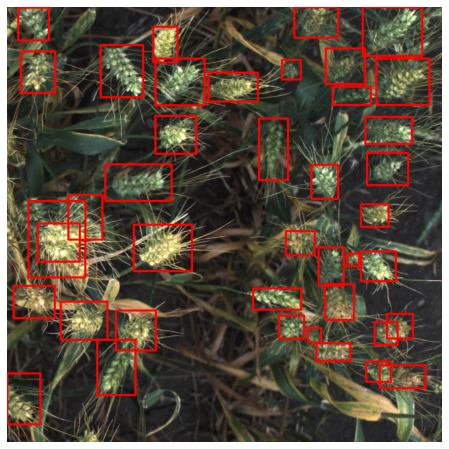

In [17]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# retrain Faster RCNN

In [18]:
model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
#lr_scheduler = None

num_epochs = 4

loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
  

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 0.42313218116760254
Iteration #100 loss: 0.6134706735610962
Iteration #150 loss: 0.6470072269439697
Iteration #200 loss: 0.675960898399353
Iteration #250 loss: 0.7267295122146606
Iteration #300 loss: 0.6691184639930725
Iteration #350 loss: 0.39233145117759705
Iteration #400 loss: 0.45028072595596313
Iteration #450 loss: 0.4222228527069092
Iteration #500 loss: 0.47859513759613037
Iteration #550 loss: 0.8412362933158875
Iteration #600 loss: 0.4718817472457886
Iteration #650 loss: 0.6379114389419556
Iteration #700 loss: 0.3979249894618988
Iteration #750 loss: 0.4181019961833954
Iteration #800 loss: 0.7451682686805725
Epoch #0 loss: 0.570504551872294
Iteration #850 loss: 0.7722434401512146
Iteration #900 loss: 0.7742406129837036
Iteration #950 loss: 0.6065548062324524
Iteration #1000 loss: 0.6643500328063965
Iteration #1050 loss: 0.7095586061477661
Iteration #1100 loss: 0.7282335162162781
Iteration #1150 loss: 0.6094719767570496
Iteration #1200 loss: 0.3751192092895508


In [19]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn2nd.pth')

# ** final Inference and submission

In [13]:
model.eval()
detection_threshold = 0.5
results = []
for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        
            
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

In [14]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9980 549 537 131 187 0.9969 24 453 108 162 0...
1,51f1be19e,0.9968 266 470 147 129 0.9956 610 87 160 184 0...
2,f5a1f0358,0.9950 131 753 169 123 0.9948 533 269 120 121 ...
3,796707dd7,0.9920 894 329 114 97 0.9882 503 790 96 98 0.9...
4,51b3e36ab,0.9991 534 33 254 135 0.9986 868 286 156 147 0...


In [15]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)


In [16]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)


In [18]:
test_df.to_csv(f'{DIR_INPUT}submission.csv', index=False)